# Wine Quality Analysis

<img src="https://thumbor.forbes.com/thumbor/fit-in/1200x0/filters%3Aformat%28jpg%29/https%3A%2F%2Fspecials-images.forbesimg.com%2Fdam%2Fimageserve%2F1133888244%2F0x0.jpg%3Ffit%3Dscale" width="600px" />

This notebook analyse a database of **red** and **white** variants of the Portuguese "Vinho Verde" wine based on wine **physicochemical test results** and quality scores that experts assign to each wine sample.

In [111]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer, PolynomialFeatures, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate, GridSearchCV, cross_val_predict
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn import set_config
from sklearn.utils.multiclass import unique_labels

In [89]:
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_theme(style='whitegrid')
set_config(display='diagram')


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [56]:
full_df = pd.read_csv('data/winequalityN.csv')

full_df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


# Classification Objective

The most obvious classification objective for this training set is **multiclass wine quality classification**. 

The dataset is **higly imbalanced**. We have only 5 samples of exellent wines and 30 samples of the lowest quality wines. If we take into account test set split and cross-validation folds, we may have only a couple of examples during training. This means that there may be a problem of applying SMOTE and similar synthetical methods to balance datasets as they would require more samples to create clusters for samplings from.

Other possible objectives are:
- multiclass quality classification with only 3 classes: low, medium, high quality wines
- binary quality classification: good or bad quality wine
- binary wine type classification: red or white wine (which would also suffer from imbalance, but could be fixed by synthetic resampling)

In [57]:
full_df['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

We will stick with **multiclass quality classification** and 3 classes: low, medium, high quality wines:

In [58]:
def impute_quality_group(quality):
    if quality <= 5:
        return 0 # low
    if quality > 5 and quality < 7:
        return 1 # average
    if quality >= 7:
        return 2 # high

full_df['quality_group'] = full_df['quality'].apply(impute_quality_group)

In [59]:
full_df['quality_group'].value_counts()

1    2836
0    2384
2    1277
Name: quality_group, dtype: int64

# Model

In [62]:
def plot_confusion_matrix_by_predictions(y_true, y_predicted, *, labels=None,
                          sample_weight=None, normalize=None,
                          display_labels=None, include_values=True,
                          xticks_rotation='horizontal',
                          values_format=None, colorbar=False,
                          cmap='viridis', ax=None):
    
    cm = confusion_matrix(y_true, y_predicted, sample_weight=sample_weight,
                          labels=labels, normalize=normalize)

    if display_labels is None:
        if labels is None:
            display_labels = unique_labels(y_true, y_predicted)
        else:
            display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format, colorbar=colorbar)


In [63]:
def score_classification_model(model, X_train, y_train):
    
    cv_scores = cross_validate(
        model, X_train, y_train, 
        scoring=['f1_weighted', 'balanced_accuracy', 'accuracy'],
        cv=5,
        n_jobs=-1, verbose=0
    )

    cv_y_predicted = cross_val_predict(
        model, X_train, y_train,
        cv=5,
        n_jobs=-1
    )

    cv_f1_weighted, f1_weighted_std = cv_scores['test_f1_weighted'].mean(), cv_scores['test_f1_weighted'].std()
    cv_balanced_accuracy, balanced_accuracy_std = cv_scores['test_balanced_accuracy'].mean(), cv_scores['test_balanced_accuracy'].std()
    cv_accuracy, balanced_std = cv_scores['test_accuracy'].mean(), cv_scores['test_accuracy'].std()

    model.fit(X_train, y_train)

    y_train_predicted = model.predict(X_train)

    train_f1_weighted = f1_score(y_train, y_train_predicted, average='weighted')
    train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_predicted)

    print('[Train] F1 Weighted: %.4f' % (train_f1_weighted))
    print('[Train] Balanced Accuracy: %.4f' % (train_balanced_accuracy))
    print('Train Set Report:')
    print(classification_report(y_train, y_train_predicted, digits=3))

    print('[CV] F1 Weighted: %.4f (%.4f)' % (cv_f1_weighted, f1_weighted_std))
    print('[CV] Balanced Accuracy: %.4f (%.4f)' % (cv_balanced_accuracy, balanced_accuracy_std))
    print('[CV] Accuracy: %.4f (%.4f)' % (cv_accuracy, balanced_std))
    print('CV Report:')
    print(classification_report(y_train, cv_y_predicted, digits=3))
    
    # display confusion matrixes

    _, (ax0, ax1) = plt.subplots(1, 2)

    ax0.set_title('Train Confusion Matrix')
    plot_confusion_matrix(
        model, X_train, y_train,
        cmap=plt.cm.Blues,
        normalize='true',
        ax=ax0,
        colorbar=False,
    )

    ax1.set_title('CV Confusion Matrix')
    plot_confusion_matrix_by_predictions(
        y_train, cv_y_predicted,
        cmap=plt.cm.Blues,
        normalize='true',
        ax=ax1,
        colorbar=False,
    )

In [64]:
# sklearn's pipeline API is limited at this point and doesn't provide a way to get columns of transformed X array
# This snippet will cover our back 

def get_columns_from_transformer(column_transformer, input_colums):    
    col_name = []

    for transformer_in_columns in column_transformer.transformers_[:-1]: #the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names(raw_col_name)
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)

    [_, _, reminder_columns] = column_transformer.transformers_[-1]

    for col_idx in reminder_columns:
        col_name.append(input_colums[col_idx])

    return col_name

# Feature Engineering

In [121]:
for feature in ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'pH', 'sulphates']:
    full_df[feature] = full_df.groupby(['type'])[feature].transform(lambda x: x.fillna(x.median()))

In [122]:
full_df['fixed_acidity_red_wine'] = (full_df['type'] == 'red') * full_df['fixed acidity']
full_df['fixed_acidity_white_wine'] = (full_df['type'] == 'white') * full_df['fixed acidity']

full_df['molecular_sulfur_dioxid'] = full_df['free sulfur dioxide'] / (1 + 10 ** (full_df['pH'] - 1.8))
full_df['free_total_so2_rate'] = full_df['free sulfur dioxide'] / full_df['total sulfur dioxide']
full_df['bound_sulfur_dioxid'] = full_df['total sulfur dioxide'] - full_df['free sulfur dioxide']

Feature Engineering:
- `total sulfur dioxide` - doesn't improve models in a raw view
- `free_total_so2_rate` - brings 0 improvements

In [195]:
model_features = [
    'type',
    'alcohol',
    'fixed acidity',
    'volatile acidity',
    'citric acid',
    'pH',
    'residual sugar',
    'free sulfur dioxide',
    'chlorides',
    'density',
    'sulphates',
    'bound_sulfur_dioxid',
    'molecular_sulfur_dioxid'
]

X = full_df[model_features]
y = full_df['quality_group']

stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

for train_idx, test_idx in stratified_splitter.split(X, y):
    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_test, y_test = X.loc[test_idx], y.loc[test_idx]

# Data Processing

In [196]:
oneplus_transformer = FunctionTransformer(func=lambda x: 1 + x, inverse_func=lambda x: 1 - x)
boxcox_transformer = PowerTransformer(method='box-cox', standardize=False)

numerical_transformer = Pipeline([
    ('positive_transforming', oneplus_transformer),
    ('boxcox_transforming', boxcox_transformer),
])

feature_transformer = ColumnTransformer([
        ('feature_transforming', numerical_transformer, [
            'fixed acidity', 'chlorides', 'citric acid', 'volatile acidity', 
            'sulphates', 'alcohol', 'residual sugar', 'free sulfur dioxide', 
            'sulphates', 'pH'
        ]),
        ('wine_type_onehot', OneHotEncoder(), ['type']),
    ],
    remainder='passthrough'
)

# LogisticRegression

In [197]:
logistic_regression = LogisticRegression(
    solver='liblinear',
    penalty='l1',
    C=0.95,
    max_iter=500,
    class_weight='balanced',
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

logistic_regression_pipeline = Pipeline([
    ('feature_processing', feature_transformer),
    ('scaling', StandardScaler()),
    ('quality_classification', logistic_regression),
])

logistic_regression_pipeline

Pipeline(steps=[('feature_processing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('feature_transforming',
                                                  Pipeline(steps=[('positive_transforming',
                                                                   FunctionTransformer(func=<function <lambda> at 0x13ff76670>,
                                                                                       inverse_func=<function <lambda> at 0x13ff764c0>)),
                                                                  ('boxcox_transforming',
                                                                   PowerTransformer(method='box-cox',
                                                                                    standardize=False))]),
                                                  ['fixed a...', 'chlorides',
                                                   'citric acid',
                                                   'volatile acidity',
                                                   'sulphates', 'alcohol',
                                                   'residual sugar',
                                                   'free sulfur dioxide',
                                                   'sulphates', 'pH']),
                                                 ('wine_type_onehot',
                                                  OneHotEncoder(),
                                                  ['type'])])),
                ('scaling', StandardScaler()),
                ('quality_classification',
                 LogisticRegression(C=0.95, class_weight='balanced',
                                    max_iter=500, n_jobs=-1, penalty='l1',
                                    random_state=42, solver='liblinear'))])

[Train] F1 Weighted: 0.5731
[Train] Balanced Accuracy: 0.5918
Train Set Report:
              precision    recall  f1-score   support

           0      0.630     0.725     0.674      1907
           1      0.579     0.443     0.502      2269
           2      0.489     0.607     0.542      1021

    accuracy                          0.579      5197
   macro avg      0.566     0.592     0.573      5197
weighted avg      0.580     0.579     0.573      5197

[CV] F1 Weighted: 0.5690 (0.0142)
[CV] Balanced Accuracy: 0.5866 (0.0101)
[CV] Accuracy: 0.5746 (0.0116)
CV Report:
              precision    recall  f1-score   support

           0      0.630     0.719     0.672      1907
           1      0.575     0.442     0.500      2269
           2      0.480     0.598     0.533      1021

    accuracy                          0.575      5197
   macro avg      0.561     0.587     0.568      5197
weighted avg      0.576     0.575     0.569      5197



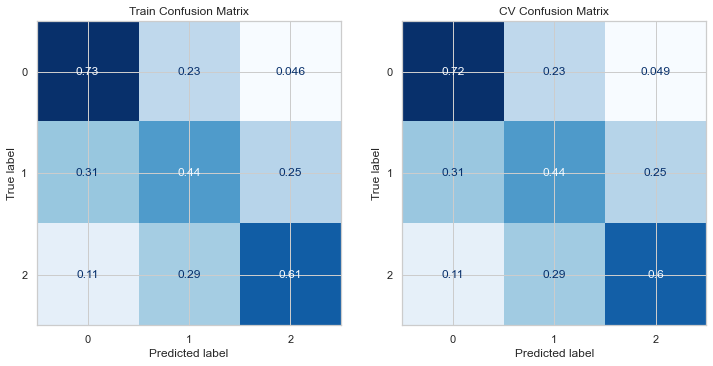

In [198]:
score_classification_model(logistic_regression_pipeline, X_train, y_train)

## Hyperparam Tuning

In [75]:
parameters = {
    'quality_classification__penalty': ['l2', 'l1', 'elasticnet', 'none'], # 'l1', 'elasticnet', 'none'
    'quality_classification__C': [1.0, 0.95, 0.9, 0.8], # 1.0
    'quality_classification__tol': [1e-4],
    'quality_classification__class_weight': ['balanced'],
    'quality_classification__solver': ['lbfgs', 'liblinear', 'sag', 'saga'], # lbfgs
    'quality_classification__max_iter': [2000, 2500],
    'quality_classification__l1_ratio': [1.0, 0.0, 0.3, 0.4, 0.5],
}

param_searcher = GridSearchCV(
   estimator=logistic_regression_pipeline,
   scoring='balanced_accuracy',
   param_grid=parameters,
   cv=5,
   n_jobs=-1, 
   verbose=3
)

#param_searcher.fit(X_train, y_train)
#param_searcher.best_params_, param_searcher.best_score_

# Polynomial Regression

In [199]:
logistic_classifier = LogisticRegression(
    penalty='none',
    solver='newton-cg',
    class_weight='balanced',
    random_state=RANDOM_SEED,
)

polynomial_pipeline = Pipeline([
    ('feature_processing', feature_transformer),
    ('polynomial_features', PolynomialFeatures(interaction_only=True)),
    ('scaling', StandardScaler()),
    ('quality_classification', logistic_classifier),
])

polynomial_pipeline

Pipeline(steps=[('feature_processing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('feature_transforming',
                                                  Pipeline(steps=[('positive_transforming',
                                                                   FunctionTransformer(func=<function <lambda> at 0x13ff76670>,
                                                                                       inverse_func=<function <lambda> at 0x13ff764c0>)),
                                                                  ('boxcox_transforming',
                                                                   PowerTransformer(method='box-cox',
                                                                                    standardize=False))]),
                                                  ['fixed a...
                                                   'volatile acidity',
                                                   'sulphates', 'alcohol',
                                                   'residual sugar',
                                                   'free sulfur dioxide',
                                                   'sulphates', 'pH']),
                                                 ('wine_type_onehot',
                                                  OneHotEncoder(),
                                                  ['type'])])),
                ('polynomial_features',
                 PolynomialFeatures(interaction_only=True)),
                ('scaling', StandardScaler()),
                ('quality_classification',
                 LogisticRegression(class_weight='balanced', penalty='none',
                                    random_state=42, solver='newton-cg'))])

[Train] F1 Weighted: 0.5959
[Train] Balanced Accuracy: 0.6327
Train Set Report:
              precision    recall  f1-score   support

           0      0.678     0.745     0.710      1907
           1      0.615     0.430     0.506      2269
           2      0.487     0.723     0.582      1021

    accuracy                          0.603      5197
   macro avg      0.593     0.633     0.599      5197
weighted avg      0.613     0.603     0.596      5197

[CV] F1 Weighted: 0.5764 (0.0064)
[CV] Balanced Accuracy: 0.6150 (0.0129)
[CV] Accuracy: 0.5844 (0.0083)
CV Report:
              precision    recall  f1-score   support

           0      0.657     0.723     0.688      1907
           1      0.588     0.411     0.484      2269
           2      0.479     0.711     0.573      1021

    accuracy                          0.584      5197
   macro avg      0.575     0.615     0.582      5197
weighted avg      0.592     0.584     0.576      5197



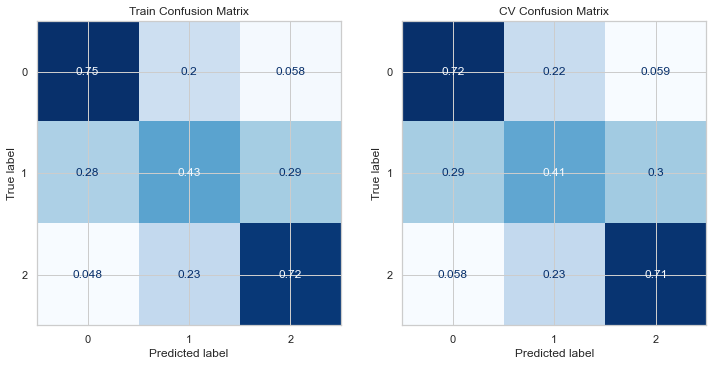

In [200]:
score_classification_model(polynomial_pipeline, X_train, y_train)

### Hyperparam Tuning

In [78]:
parameters = [
    {
        'quality_classification__solver': ['newton-cg'], # lbfgs, liblinear, 'lbfgs', 'sag', 'saga',
        'quality_classification__penalty': ['l2', 'l1', 'elasticnet', 'none'], # 'l1', 'elasticnet', 'none'
        'quality_classification__C': [1.0], # 1.0
        'quality_classification__l1_ratio': [1.0, 0.9],
        'quality_classification__max_iter': [100],
        'quality_classification__class_weight': ['balanced'],
        'polynomial_features__degree': [2],
        'polynomial_features__interaction_only': [True],
    },
]

param_searcher = GridSearchCV(
   estimator=polynomial_pipeline,
   scoring='balanced_accuracy',
   param_grid=parameters,
   cv=5,
   n_jobs=-1, 
   verbose=3
)

param_searcher.fit(X_train, y_train)
param_searcher.best_params_, param_searcher.best_score_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


({'polynomial_features__degree': 2,
  'polynomial_features__interaction_only': True,
  'quality_classification__C': 1.0,
  'quality_classification__class_weight': 'balanced',
  'quality_classification__l1_ratio': 1.0,
  'quality_classification__max_iter': 100,
  'quality_classification__penalty': 'none',
  'quality_classification__solver': 'newton-cg'},
 0.3615735472545015)

## RandomForest

In [201]:
rf_classifier = RandomForestClassifier(
    criterion='entropy',
    n_estimators=60,
    min_samples_split=20,
    min_samples_leaf=5,
    max_features='sqrt',
    class_weight='balanced',
    random_state=RANDOM_SEED,
)

rf_pipeline = Pipeline([
    ('feature_processing', feature_transformer),
    ('quality_classification', rf_classifier),
])

rf_pipeline


Pipeline(steps=[('feature_processing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('feature_transforming',
                                                  Pipeline(steps=[('positive_transforming',
                                                                   FunctionTransformer(func=<function <lambda> at 0x13ff76670>,
                                                                                       inverse_func=<function <lambda> at 0x13ff764c0>)),
                                                                  ('boxcox_transforming',
                                                                   PowerTransformer(method='box-cox',
                                                                                    standardize=False))]),
                                                  ['fixed a...des',
                                                   'citric acid',
                                                   'volatile acidity',
                                                   'sulphates', 'alcohol',
                                                   'residual sugar',
                                                   'free sulfur dioxide',
                                                   'sulphates', 'pH']),
                                                 ('wine_type_onehot',
                                                  OneHotEncoder(),
                                                  ['type'])])),
                ('quality_classification',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy',
                                        max_features='sqrt', min_samples_leaf=5,
                                        min_samples_split=20, n_estimators=60,
                                        random_state=42))])

[Train] F1 Weighted: 0.8518
[Train] Balanced Accuracy: 0.8696
Train Set Report:
              precision    recall  f1-score   support

           0      0.854     0.880     0.867      1907
           1      0.887     0.791     0.836      2269
           2      0.793     0.938     0.860      1021

    accuracy                          0.852      5197
   macro avg      0.844     0.870     0.854      5197
weighted avg      0.856     0.852     0.852      5197

[CV] F1 Weighted: 0.6520 (0.0171)
[CV] Balanced Accuracy: 0.6721 (0.0218)
[CV] Accuracy: 0.6546 (0.0184)
CV Report:
              precision    recall  f1-score   support

           0      0.698     0.744     0.720      1907
           1      0.653     0.548     0.596      2269
           2      0.587     0.724     0.648      1021

    accuracy                          0.655      5197
   macro avg      0.646     0.672     0.655      5197
weighted avg      0.657     0.655     0.652      5197



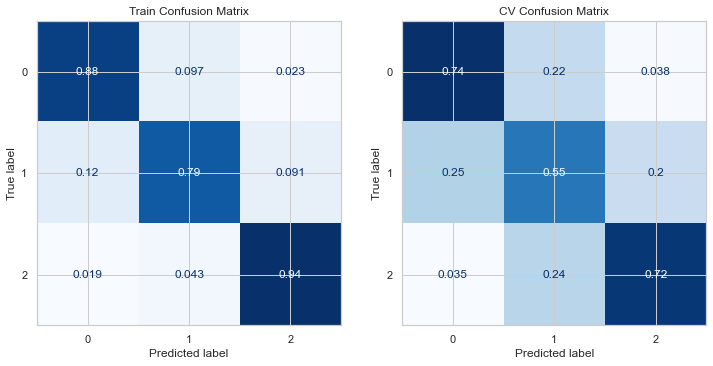

In [202]:
score_classification_model(rf_pipeline, X_train, y_train)

### Hyperparam Tuning

In [81]:
parameters = {
    'quality_classification__n_estimators': [50, 100, 150, 200],
    'quality_classification__criterion': ['entropy'], # 'gini',
    'quality_classification__max_features': [None, 'sqrt', 'log2', 'auto'],
    'quality_classification__max_depth': [None], # 3, 4, 5
    'quality_classification__min_samples_split': [15, 20, 25], # 2
    'quality_classification__min_samples_leaf': [4, 5, 6], # 2
    'quality_classification__class_weight': ['balanced'],
}

param_searcher = GridSearchCV(
   estimator=rf_pipeline,
   scoring='balanced_accuracy',
   param_grid=parameters,
   cv=5,
   n_jobs=-1, 
   verbose=3
)

#param_searcher.fit(X_train, y_train)
#param_searcher.best_params_, param_searcher.best_score_

# Model Inspection

In [203]:
X_train_processed_columns = get_columns_from_transformer(rf_pipeline.named_steps['feature_processing'], list(X_train.columns))

In [204]:
features_list = sorted(zip(rf_pipeline.named_steps['quality_classification'].feature_importances_, X_train_processed_columns), reverse=True)
features_list

[(0.19723185280219122, 'alcohol'),
 (0.10322554273940834, 'volatile acidity'),
 (0.10200682974812776, 'density'),
 (0.07410343727566973, 'chlorides'),
 (0.07269176208492185, 'citric acid'),
 (0.06975802319535428, 'bound_sulfur_dioxid'),
 (0.062005577037719035, 'residual sugar'),
 (0.0591845693973598, 'free sulfur dioxide'),
 (0.05693670664978083, 'molecular_sulfur_dioxid'),
 (0.05328788906030491, 'pH'),
 (0.05043124085239049, 'sulphates'),
 (0.04748271157001811, 'sulphates'),
 (0.04508053382142858, 'fixed acidity'),
 (0.004380639779789881, 'type_red'),
 (0.002192683985535145, 'type_white')]

In [84]:
# from eli5.sklearn import PermutationImportance
# from eli5 import show_weights

# X_train_processed = rf_pipeline.named_steps['feature_processing'].transform(X_train)

# permutation_importance = PermutationImportance(
#     rf_classifier, 
#     scoring='balanced_accuracy',
#     #cv=5,
#     random_state=RANDOM_SEED,
# )

# permutation_importance.fit(X_train_processed, y_train)
# show_weights(permutation_importance, feature_names=X_train_processed_columns, top=20)

# Generalization

In [104]:
def score_model_generalization(model, X_test, y_test):
    y_test_predicted = model.predict(X_test)

    test_f1_weighted = f1_score(y_test, y_test_predicted, average='weighted')
    test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_predicted)

    print('[Test] F1 Weighted: %.4f' % (test_f1_weighted))
    print('[Test] Balanced Accuracy: %.4f' % (test_balanced_accuracy))
    print('Test Set Report:')
    print(classification_report(y_test, y_test_predicted, digits=3))

    plot_confusion_matrix_by_predictions(
        y_test, y_test_predicted,
        cmap=plt.cm.Greens,
        normalize='true',
        colorbar=False,
    )

## Logistic Regression

[Test] F1 Weighted: 0.5465
[Test] Balanced Accuracy: 0.5633
Test Set Report:
              precision    recall  f1-score   support

           0      0.615     0.679     0.645       477
           1      0.536     0.429     0.476       567
           2      0.466     0.582     0.517       256

    accuracy                          0.551      1300
   macro avg      0.539     0.563     0.546      1300
weighted avg      0.551     0.551     0.547      1300



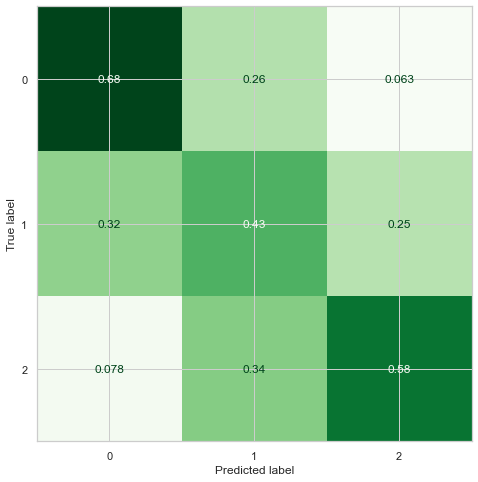

In [205]:
score_model_generalization(logistic_regression_pipeline, X_test, y_test)

## Polynomial Regression

[Test] F1 Weighted: 0.5632
[Test] Balanced Accuracy: 0.5957
Test Set Report:
              precision    recall  f1-score   support

           0      0.656     0.717     0.685       477
           1      0.570     0.402     0.472       567
           2      0.451     0.668     0.539       256

    accuracy                          0.570      1300
   macro avg      0.559     0.596     0.565      1300
weighted avg      0.578     0.570     0.563      1300



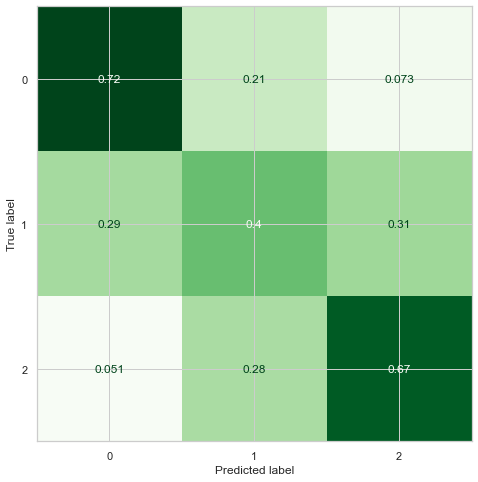

In [206]:
score_model_generalization(polynomial_pipeline, X_test, y_test)

## Random Forest

[Test] F1 Weighted: 0.6584
[Test] Balanced Accuracy: 0.6717
Test Set Report:
              precision    recall  f1-score   support

           0      0.722     0.730     0.726       477
           1      0.647     0.578     0.611       567
           2      0.582     0.707     0.638       256

    accuracy                          0.659      1300
   macro avg      0.650     0.672     0.658      1300
weighted avg      0.662     0.659     0.658      1300



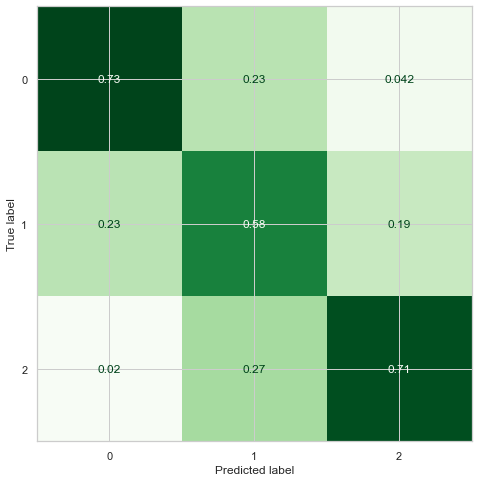

In [207]:
score_model_generalization(rf_pipeline, X_test, y_test)